In [1]:
import os, re, copy, pickle
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats

from sklearn import (impute, preprocessing, model_selection, 
                     metrics, linear_model, datasets, pipeline)

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.path import Path
import matplotlib.patches as patches

In [2]:
# Limit to a specific GPU
RUN = 0
NRUNS = 1
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str((RUN%4))

In [3]:
REPS = 200

In [4]:
X = pd.read_csv('./X_sparsity.csv',index_col=0)
y = np.load('./y_sparsity.npy')

In [5]:
OUTPATH = 'results'
OUTPATH_BASELINE = 'results'

In [6]:
def get_data(rseed):
    Xtv, Xtest, ytv, ytest = model_selection.train_test_split(X,y,train_size=200,random_state=rseed)
    Xtrain, Xvalid, ytrain, yvalid = model_selection.train_test_split(Xtv,ytv,train_size=100,random_state=rseed)
    
    imp = impute.SimpleImputer()
    ss = preprocessing.StandardScaler()

    Xtrain_imp = imp.fit_transform(Xtrain)
    Xvalid_imp = imp.transform(Xvalid)
    Xtest_imp = imp.transform(Xtest)
    
    Xtrain_ss = ss.fit_transform(Xtrain_imp)
    Xvalid_ss = ss.transform(Xvalid_imp)
    Xtest_ss = ss.transform(Xtest_imp)
    
    return Xtrain_ss, Xvalid_ss, Xtest_ss, ytrain, yvalid, ytest


## Prepare data for plotting

In [7]:
all_models = defaultdict(list)

for i in range(0,1):#NRUNS):
    # Most models
    with open(f'{OUTPATH}/{REPS}reps_{i}_all.pkl','rb') as f:
        tmodels = pickle.load(f)
    for k in tmodels:
        all_models[k].extend(tmodels[k])
# Unreg models
with open(f'{OUTPATH_BASELINE}/{REPS}reps_0_unreg.pkl','rb') as f:
    tmodels = pickle.load(f)
    all_models['unreg'].append(tmodels)
with open(f'{OUTPATH_BASELINE}/{REPS}reps_0_unreg_nobias.pkl','rb') as f:
    tmodels = pickle.load(f)
    all_models['unreg_nobias'].append(tmodels)
models = all_models

In [8]:
print(f"Dimensions of all_models:\n(Penalties x Strengths x Reps x Fields)\n{len(all_models), len(models['ginieg']), len(models['ginieg'][0]), len(models['ginieg'][0][0])}")

Dimensions of all_models:
(Penalties x Strengths x Reps x Fields)
(6, 5, 200, 3)


In [9]:
validscores = {k: np.array([[t[0] for t in r] for r in all_models[k]]) for k in all_models}
best_hp_idxs = {}

testscores = {}
valattribution = {}

for m in all_models:
    idx = validscores[m].mean(1).argmax()
    best_hp_idxs[m] = int(idx)
        
    testscores[m] = all_models[m][idx]


print('Best regularization strength:')
reg_strengths = [1e-2, 1e-1, 1e+0, 1e+1, 1e+2] # they are searched in the training process
for key in best_hp_idxs:
    idx = best_hp_idxs[key]
    reg_strength = reg_strengths[idx]
    print('Attribution:', key, 'Best Idx:', idx, 'Best Reg Strength:', reg_strength)
    
testscores = {k: np.array([[t[1] for t in r] for r in all_models[k]]) for k in all_models}

Best regularization strength:
Attribution: giniross Best Idx: 1 Best Reg Strength: 0.1
Attribution: ginigrad Best Idx: 1 Best Reg Strength: 0.1
Attribution: giniinputxgrad_nobias Best Idx: 2 Best Reg Strength: 1.0
Attribution: ginieg Best Idx: 2 Best Reg Strength: 1.0
Attribution: unreg Best Idx: 0 Best Reg Strength: 0.01
Attribution: unreg_nobias Best Idx: 0 Best Reg Strength: 0.01


## Plots

0.7673262565322271
Dimensions of all_models:
(Penalties x Strengths x Reps x Fields)
(8, 1, 200, 3)


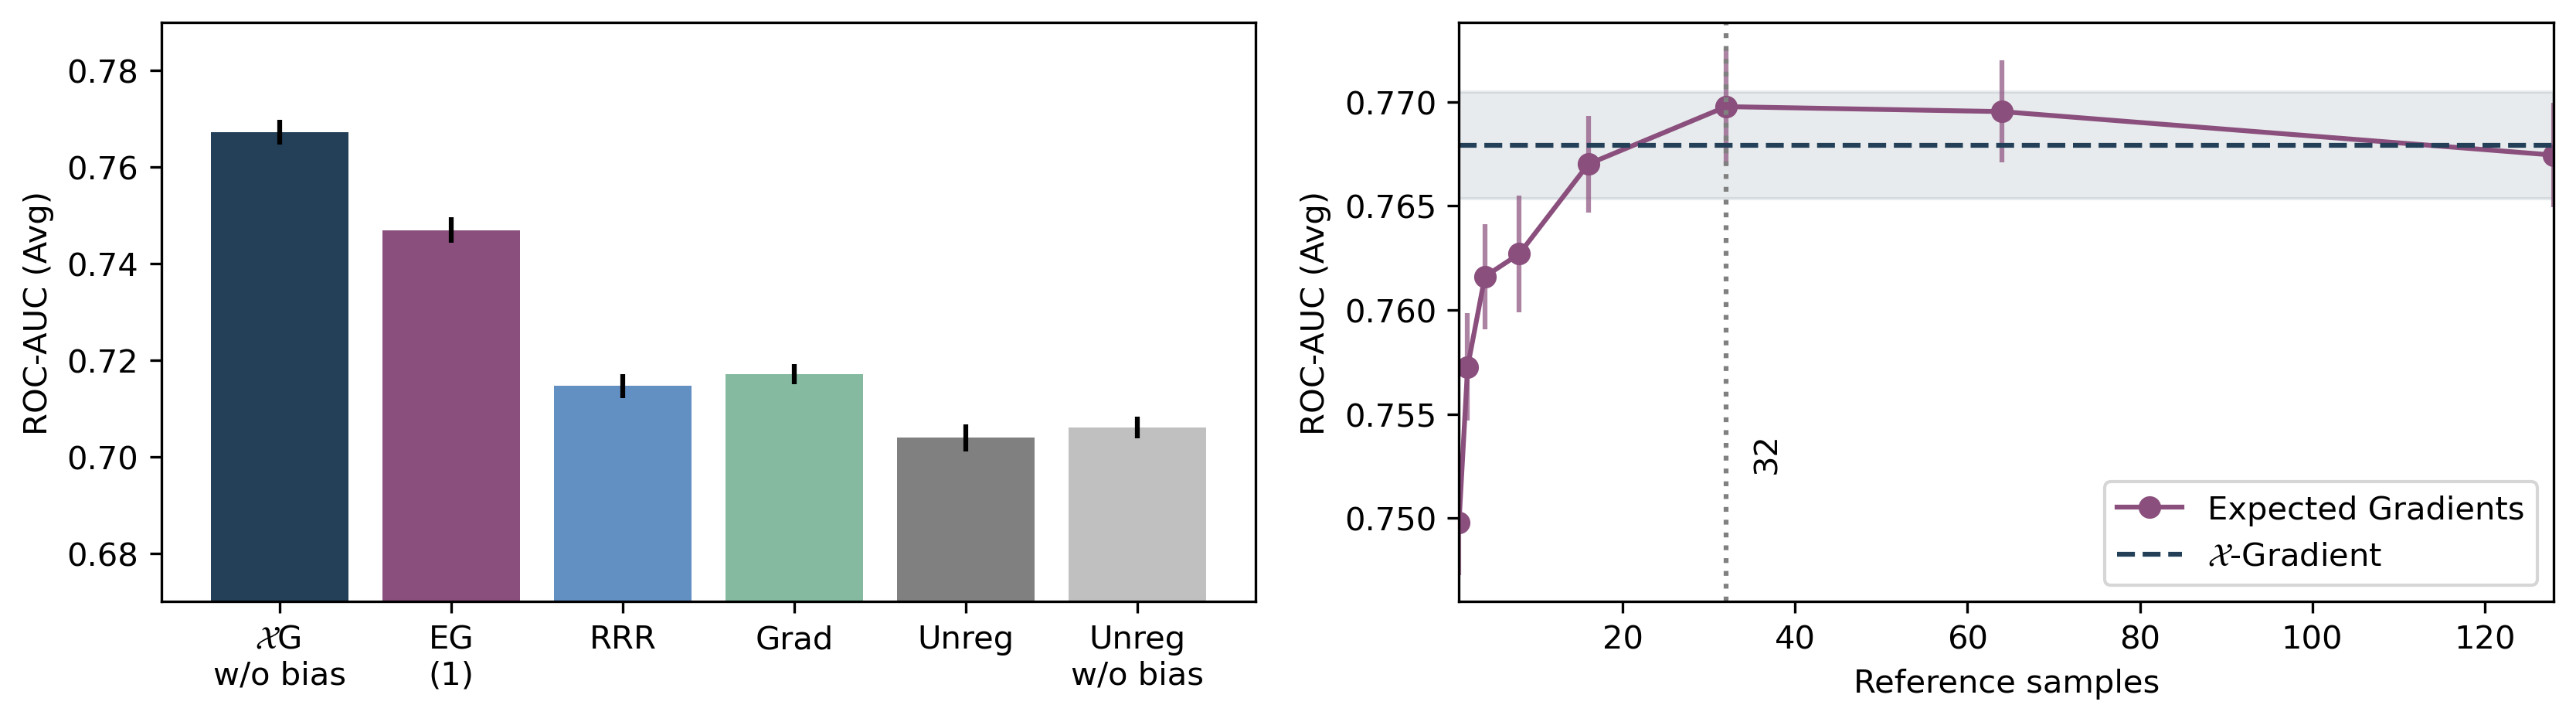

In [10]:
# Expanded names for methods
main_map = {
    'ginieg': 'EG\n(1)',
    'ginigrad': 'Grad',
    'giniinputxgrad_nobias': r'$\mathcal{X}$G' +' \nw/o bias',
    'giniross': 'RRR',
    'unreg': "Unreg",
    'unreg_nobias': "Unreg\nw/o bias"
}
# Map colors to methods for plotting
color_map = {
    'ginieg': '#8A4F7D',
    'ginigrad': '#85BAA1',
    'giniross': '#6290C3',
    'unreg': "gray",
    'unreg_nobias': "silver",
    'giniinputxgrad_nobias': '#234058'
}

#plt.rc('text', usetex=True)

#plt.rcParams['mathtext.fontset'] = 'custom'
#plt.rcParams['mathtext.rm'] = 'Times New Roman'
#plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
#plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["font.size"] = 15


# Generate plot
msort = ['giniinputxgrad_nobias', 'ginieg','giniross','ginigrad','unreg', 'unreg_nobias']

fig, axarr = plt.subplots(1,2,figsize=(11,3),dpi=300,constrained_layout=True)

from scipy.stats import sem
axarr[0].bar(np.arange(len(msort)),
        [testscores[m][best_hp_idxs[m]].mean() for m in msort], 
        tick_label=[main_map[m] for m in msort],
       color = [color_map[m] for m in msort])

print(testscores['giniinputxgrad_nobias'].mean(1).max())

axarr[0].errorbar(np.arange(len(msort)),
             [testscores[m][best_hp_idxs[m]].mean() for m in msort],
             yerr=[sem(testscores[m][best_hp_idxs[m]]) for m in msort], 
             fmt='none',color='black')
axarr[0].set_ylim(0.67,0.79)
axarr[0].set_ylabel("ROC-AUC (Avg)")

eg_models = {}
i = 0

with open(f'{OUTPATH}/{REPS}reps_{i}_eg_refs_powers_of_two.pkl','rb') as f:
    tmodels = pickle.load(f)
for k in tmodels:
    eg_models[k] = tmodels[k]

print(f"Dimensions of all_models:\n(Penalties x Strengths x Reps x Fields)\n{len(eg_models), len(eg_models['ginieg1']), len(eg_models['ginieg1'][0]), len(eg_models['ginieg1'][0][0])}")
      
testscores2 = {k: np.array([[t[1] for t in r] for r in eg_models[k]]) for k in eg_models}

xs = [1,2,4,8,16,32,64,128]
ys = []
se = []
ys2 = [0.7679,0.7679,0.7679,0.7679,0.7679,0.7679,0.7679,0.7679]

ys2_upper =  list(map(lambda x: x + sem(testscores['giniinputxgrad_nobias'][best_hp_idxs['giniinputxgrad_nobias']]), ys2))
ys2_lower =  list(map(lambda x: x - sem(testscores['giniinputxgrad_nobias'][best_hp_idxs['giniinputxgrad_nobias']]), ys2))



for m in eg_models:
    ys.append(testscores2[m].mean())
    se.append(sem(testscores2[m][0]))
    

line1, = axarr[1].plot(xs,ys, linestyle='-', marker='o', color=color_map['ginieg'])

axarr[1].errorbar(xs,ys, yerr=se, 
             fmt='none',color=color_map['ginieg'],alpha=0.7)

line2, = axarr[1].plot(xs,ys2, linestyle="--", color=color_map['giniinputxgrad_nobias'])

axarr[1].fill_between(xs, ys2_lower, ys2_upper, alpha=0.1, color=color_map['giniinputxgrad_nobias'])
axarr[1].set_xlim([1, 128])
axarr[1].axvline(x=32, linestyle="dotted", color="gray")
axarr[1].text(35,0.7525,'32',rotation=90)
      
axarr[1].set_xlabel("Reference samples")
axarr[1].set_ylabel("ROC-AUC (Avg)")
axarr[1].legend([line1, line2], ['Expected Gradients', r'$\mathcal{X}$-Gradient'], loc='lower right')
      
plt.savefig('sparsity_maintext.pdf',bbox_inches='tight')
